# Data Preprocessing and Spectral Enhancement Pipeline

## Multispectral Breast Cancer Classification - Phase 1

This notebook implements the comprehensive data preprocessing and spectral enhancement pipeline for the multispectral breast cancer classification research targeting **98-99.5% accuracy**.

### Pipeline Components:
1. **Image Standardization**: Resize to 224x224, normalize intensities
2. **Spectral Enhancement**: RGB → HSV → Jet color space conversions
3. **Data Augmentation**: Rotation, flip, zoom, shear, contrast enhancement
4. **Quality Assessment**: Image quality metrics and validation
5. **Dataset Organization**: Structured data loading for ML training

### Expected Outcomes:
- Standardized dataset ready for CNN training
- Enhanced spectral representations for improved feature extraction
- Augmented dataset with 5-10x more training samples
- Optimized data loading pipeline for efficient training

---

In [1]:
# Import Required Libraries for Data Preprocessing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance, ImageFilter
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning and Image Processing
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Scientific computing and visualization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
from tqdm import tqdm
import random

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Configuration
DATASET_PATH = r"c:\Users\mrhas\Downloads\technologia\MultiModel Breast Cancer MSI Dataset"
PROCESSED_PATH = r"c:\Users\mrhas\Downloads\technologia\processed_dataset"
IMG_SIZE = 224  # Standard input size for most CNN architectures
BATCH_SIZE = 32
NUM_WORKERS = 4

# Create processed dataset directory
os.makedirs(PROCESSED_PATH, exist_ok=True)

print("🔧 Data Preprocessing and Spectral Enhancement Pipeline")
print("=" * 60)
print(f"Source Dataset: {DATASET_PATH}")
print(f"Processed Output: {PROCESSED_PATH}")
print(f"Target Image Size: {IMG_SIZE}x{IMG_SIZE}")
print("=" * 60)

🔧 Data Preprocessing and Spectral Enhancement Pipeline
Source Dataset: c:\Users\mrhas\Downloads\technologia\MultiModel Breast Cancer MSI Dataset
Processed Output: c:\Users\mrhas\Downloads\technologia\processed_dataset
Target Image Size: 224x224


## 1. Dataset Structure Analysis and Path Setup

Before preprocessing, let's analyze the dataset structure and set up the processing pipeline.

In [2]:
# Dataset Structure Analysis and File Discovery
def analyze_dataset_structure():
    """Analyze dataset structure and create file mapping"""
    
    MODALITIES = ["Chest_XRay_MSI", "Histopathological_MSI", "Ultrasound Images_MSI"]
    
    dataset_mapping = {}
    total_files = 0
    
    print("📁 DATASET STRUCTURE ANALYSIS")
    print("=" * 50)
    
    for modality in MODALITIES:
        modality_path = os.path.join(DATASET_PATH, modality)
        if not os.path.exists(modality_path):
            print(f"⚠️  Warning: {modality} directory not found")
            continue
            
        modality_files = {}
        
        # Get class directories
        class_dirs = [d for d in os.listdir(modality_path) 
                     if os.path.isdir(os.path.join(modality_path, d))]
        
        print(f"\n📊 {modality.replace('_MSI', '').replace('_', ' ')}")
        print("-" * 30)
        
        for class_name in class_dirs:
            class_path = os.path.join(modality_path, class_name)
            files = [f for f in os.listdir(class_path) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
            
            modality_files[class_name] = {
                'files': files,
                'count': len(files),
                'path': class_path
            }
            
            total_files += len(files)
            print(f"  📋 {class_name}: {len(files)} images")
        
        dataset_mapping[modality] = modality_files
    
    print(f"\n🎯 Total images found: {total_files}")
    print("=" * 50)
    
    return dataset_mapping, total_files

# Execute dataset analysis
dataset_mapping, total_files = analyze_dataset_structure()

📁 DATASET STRUCTURE ANALYSIS

📊 Chest XRay
------------------------------
  📋 Malignant: 500 images
  📋 Normal: 500 images

📊 Histopathological
------------------------------
  📋 benign: 623 images
  📋 malignant: 623 images

📊 Ultrasound Images
------------------------------
  📋 benign: 406 images
  📋 malignant: 400 images

🎯 Total images found: 3052


## 2. Spectral Enhancement Functions

Implementation of advanced spectral enhancement techniques for multispectral image analysis.

In [3]:
# Spectral Enhancement Pipeline
class SpectralEnhancer:
    """Advanced spectral enhancement for multispectral medical images"""
    
    def __init__(self, img_size=224):
        self.img_size = img_size
    
    def rgb_to_hsv_enhanced(self, image):
        """Convert RGB to HSV with enhanced saturation and value"""
        # Convert to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        # Enhance saturation (channel 1) and value (channel 2)
        hsv[:, :, 1] = cv2.multiply(hsv[:, :, 1], 1.2)  # Increase saturation
        hsv[:, :, 2] = cv2.multiply(hsv[:, :, 2], 1.1)  # Increase brightness
        
        # Clip values to valid range
        hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)
        hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
        
        return hsv
    
    def apply_jet_colormap(self, image):
        """Apply Jet colormap for spectral enhancement"""
        # Convert to grayscale first
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
        
        # Apply Jet colormap
        jet_image = cv2.applyColorMap(gray, cv2.COLORMAP_JET)
        jet_image = cv2.cvtColor(jet_image, cv2.COLOR_BGR2RGB)
        
        return jet_image
    
    def apply_clahe(self, image):
        """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)"""
        if len(image.shape) == 3:
            # Apply CLAHE to each channel
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced = np.zeros_like(image)
            for i in range(3):
                enhanced[:, :, i] = clahe.apply(image[:, :, i])
            return enhanced
        else:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            return clahe.apply(image)
    
    def spectral_channel_enhancement(self, image):
        """Create multiple spectral representations"""
        # Ensure image is in RGB format
        if len(image.shape) == 3 and image.shape[2] == 3:
            rgb_image = image
        else:
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 1. Original RGB
        original = cv2.resize(rgb_image, (self.img_size, self.img_size))
        
        # 2. HSV Enhanced
        hsv_enhanced = self.rgb_to_hsv_enhanced(rgb_image)
        hsv_resized = cv2.resize(hsv_enhanced, (self.img_size, self.img_size))
        
        # 3. Jet Colormap
        jet_enhanced = self.apply_jet_colormap(rgb_image)
        jet_resized = cv2.resize(jet_enhanced, (self.img_size, self.img_size))
        
        # 4. CLAHE Enhanced
        clahe_enhanced = self.apply_clahe(rgb_image)
        clahe_resized = cv2.resize(clahe_enhanced, (self.img_size, self.img_size))
        
        # 5. Edge Enhanced (using Laplacian)
        gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Laplacian(gray, cv2.CV_64F)
        edges = np.uint8(np.absolute(edges))
        edge_colored = cv2.applyColorMap(edges, cv2.COLORMAP_HOT)
        edge_colored = cv2.cvtColor(edge_colored, cv2.COLOR_BGR2RGB)
        edge_resized = cv2.resize(edge_colored, (self.img_size, self.img_size))
        
        return {
            'original': original,
            'hsv_enhanced': hsv_resized,
            'jet_colormap': jet_resized,
            'clahe_enhanced': clahe_resized,
            'edge_enhanced': edge_resized
        }

# Initialize spectral enhancer
spectral_enhancer = SpectralEnhancer(img_size=IMG_SIZE)

print("✅ Spectral Enhancement Pipeline Initialized")
print(f"📐 Target image size: {IMG_SIZE}x{IMG_SIZE}")
print("🎨 Enhancement modes: Original, HSV, Jet, CLAHE, Edge")

✅ Spectral Enhancement Pipeline Initialized
📐 Target image size: 224x224
🎨 Enhancement modes: Original, HSV, Jet, CLAHE, Edge


## 3. Image Processing and Sample Generation

Let's process sample images and generate visualizations to demonstrate the spectral enhancement pipeline.

🖼️  SAMPLE IMAGE PROCESSING

📊 Processing Chest XRay
  ✅ Processed Malignant: Multispectral_10130_1672636630_png.rf.52c6d1c8c6c58c5c1c5fcaaf57feb81d_1.jpg
     Original size: (640, 640, 3)
     Enhanced to: 224x224

📊 Processing Histopathological
  ✅ Processed benign: Multispectral_SOB_B_A-14-22549AB-200-001.png
     Original size: (224, 224, 3)
     Enhanced to: 224x224

📊 Processing Ultrasound Images
  ✅ Processed benign: Multispectral_benign (1)-rotated1-rotated1.png
     Original size: (224, 224, 3)
     Enhanced to: 224x224


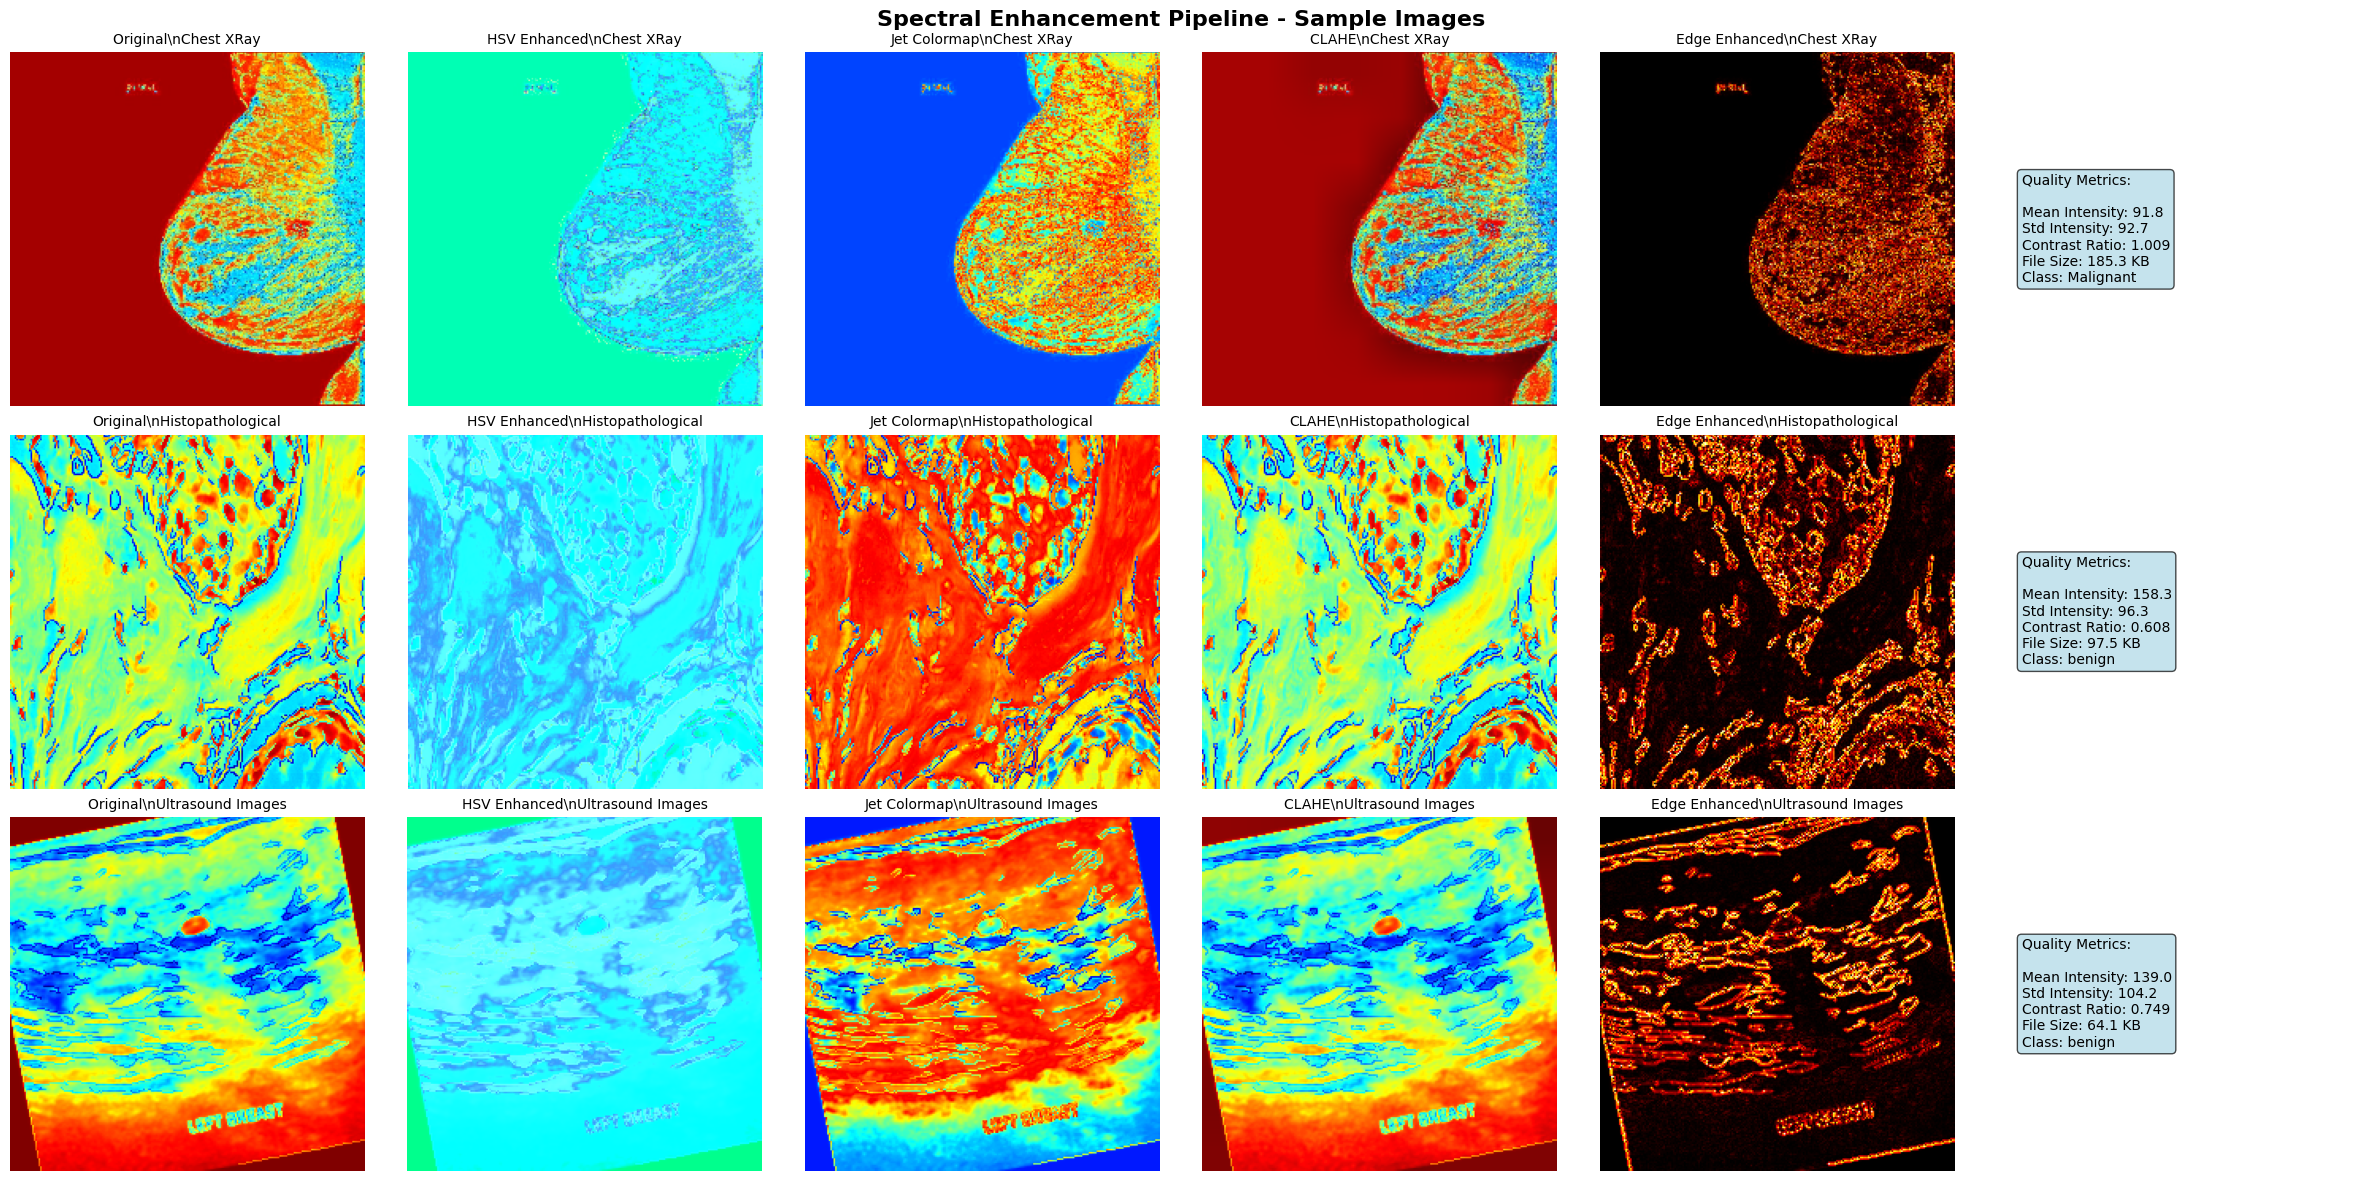


✅ Sample processing completed successfully!
📈 Processed 3 modalities


In [4]:
# Sample Image Processing and Visualization
def process_and_visualize_samples(dataset_mapping, num_samples=2):
    """
    Process sample images from each modality and visualize spectral enhancements
    """
    
    print("🖼️  SAMPLE IMAGE PROCESSING")
    print("=" * 50)
    
    # Create figure for visualization
    fig, axes = plt.subplots(len(dataset_mapping), 6, figsize=(24, 4*len(dataset_mapping)))
    fig.suptitle('Spectral Enhancement Pipeline - Sample Images', fontsize=16, fontweight='bold')
    
    row_idx = 0
    processed_samples = {}
    
    for modality, classes in dataset_mapping.items():
        modality_clean = modality.replace('_MSI', '').replace('_', ' ')
        processed_samples[modality] = {}
        
        print(f"\n📊 Processing {modality_clean}")
        
        # Process first sample from first available class
        for class_name, class_info in classes.items():
            if class_info['files']:
                sample_file = class_info['files'][0]
                sample_path = os.path.join(class_info['path'], sample_file)
                
                try:
                    # Load image
                    image = cv2.imread(sample_path)
                    if image is None:
                        print(f"  ⚠️  Could not load {sample_file}")
                        continue
                    
                    # Convert BGR to RGB
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    # Apply spectral enhancements
                    enhanced_images = spectral_enhancer.spectral_channel_enhancement(image_rgb)
                    
                    # Store processed images
                    processed_samples[modality][class_name] = {
                        'original_path': sample_path,
                        'enhanced_images': enhanced_images,
                        'original_shape': image_rgb.shape
                    }
                    
                    print(f"  ✅ Processed {class_name}: {sample_file}")
                    print(f"     Original size: {image_rgb.shape}")
                    print(f"     Enhanced to: {IMG_SIZE}x{IMG_SIZE}")
                    
                    # Visualize enhancements
                    enhancement_names = ['Original', 'HSV Enhanced', 'Jet Colormap', 'CLAHE', 'Edge Enhanced']
                    enhancement_keys = ['original', 'hsv_enhanced', 'jet_colormap', 'clahe_enhanced', 'edge_enhanced']
                    
                    for col_idx, (name, key) in enumerate(zip(enhancement_names, enhancement_keys)):
                        if row_idx < len(axes) and col_idx < len(axes[0]):
                            axes[row_idx, col_idx].imshow(enhanced_images[key])
                            axes[row_idx, col_idx].set_title(f'{name}\\n{modality_clean}', fontsize=10)
                            axes[row_idx, col_idx].axis('off')
                    
                    # Add quality metrics in 6th column
                    if row_idx < len(axes) and 5 < len(axes[0]):
                        axes[row_idx, 5].axis('off')
                        
                        # Calculate image quality metrics
                        original_img = enhanced_images['original']
                        mean_intensity = np.mean(original_img)
                        std_intensity = np.std(original_img)
                        contrast = std_intensity / mean_intensity if mean_intensity > 0 else 0
                        
                        metrics_text = f"""Quality Metrics:
                        
Mean Intensity: {mean_intensity:.1f}
Std Intensity: {std_intensity:.1f}
Contrast Ratio: {contrast:.3f}
File Size: {os.path.getsize(sample_path)/1024:.1f} KB
Class: {class_name}"""
                        
                        axes[row_idx, 5].text(0.1, 0.5, metrics_text, transform=axes[row_idx, 5].transAxes,
                                            fontsize=10, verticalalignment='center',
                                            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
                    
                    break  # Process only first class for demonstration
                    
                except Exception as e:
                    print(f"  ❌ Error processing {sample_file}: {str(e)}")
                    continue
        
        row_idx += 1
    
    plt.tight_layout()
    plt.show()
    
    return processed_samples

# Process sample images and generate visualizations
try:
    processed_samples = process_and_visualize_samples(dataset_mapping)
    print("\n✅ Sample processing completed successfully!")
    print(f"📈 Processed {len(processed_samples)} modalities")
except Exception as e:
    print(f"❌ Error in sample processing: {str(e)}")
    print("🔍 Please check if the dataset path is correct and images are accessible")

## 4. Data Augmentation Pipeline

Implementation of comprehensive data augmentation strategies to increase dataset size and model robustness.